In [2]:
import csiroct_imbl_asci as cia
import os
import os.path
import logging
import h5py
import matplotlib.pyplot as plt

run_on_asci = False

cmdXLICTPreProcSino = '/home/tho78s/development/X-TRACT-trunk/build/linux/XLIPreProcSinoMPI.exe'
cmdXLICTWorkflowMPI = '/home/tho78s/development/X-TRACT-trunk/build/linux/XLICTWorkflowMPI.exe'
cmdXLICTReconMPI = '/home/tho78s/development/X-TRACT-trunk/build/linux/XLICTReconMPI.exe'
cmdXLICOR = '/home/tho78s/development/X-TRACT-trunk/build/linux/XLICOR.exe'

dir_experiment_input_asci = '/user/home/imbl/14774/input/Lung_HRCT/19-2-R2202-Lung'
dir_experiment_output_asci = '/user/home/imbl/14774/output/Lung_HRCT/19-2-R2202-Lung'

dir_experiment_input_local = '/mnt/csiro/civ/scratch/lung/HRCT/19-2-R2173-Lung'
dir_experiment_output_local = '/mnt/Data/19-2-R2173-Lung'

if run_on_asci:
    dir_experiment_input = dir_experiment_input_asci
    dir_experiment_output = dir_experiment_output_asci   
else:
    dir_experiment_input = dir_experiment_input_local
    dir_experiment_output = dir_experiment_output_local
    
# Create the output folder if it doesn't already exist
if not os.path.exists( dir_experiment_output ):
    os.mkdir( dir_experiment_output )
    
# construct filenames
epics_flat_h5 = os.path.join( dir_experiment_input, 'BG_BEFORE.hdf' )
epics_dark_h5 = os.path.join( dir_experiment_input, 'DF_BEFORE.hdf' )
epics_sample_h5 = os.path.join( dir_experiment_input, 'SAMPLE.hdf' )

xtract_input_convert_h5 = os.path.join( dir_experiment_output, 'test_x-tract_convert.h5' )
xtract_output_ctworkflow_h5 = os.path.join( dir_experiment_output, 'test_x-tract_ctworkflow.h5' ) 
xtract_output_preproc_h5 = os.path.join( dir_experiment_output, 'test_x-tract_preproc.h5' )


In [ ]:
# Convert input EPICS HDF5 files (if required)

# Convert to X-TRACT compatible HDF5 using the same EPICS
# test file for flats, darks and samples
num_proj = cia.convert_epics_to_xtract_hdf5(
        epics_flat_h5,
        epics_dark_h5,
        epics_sample_h5,
        xtract_input_convert_h5 )

print( 'Number of copied projections =', num_proj )

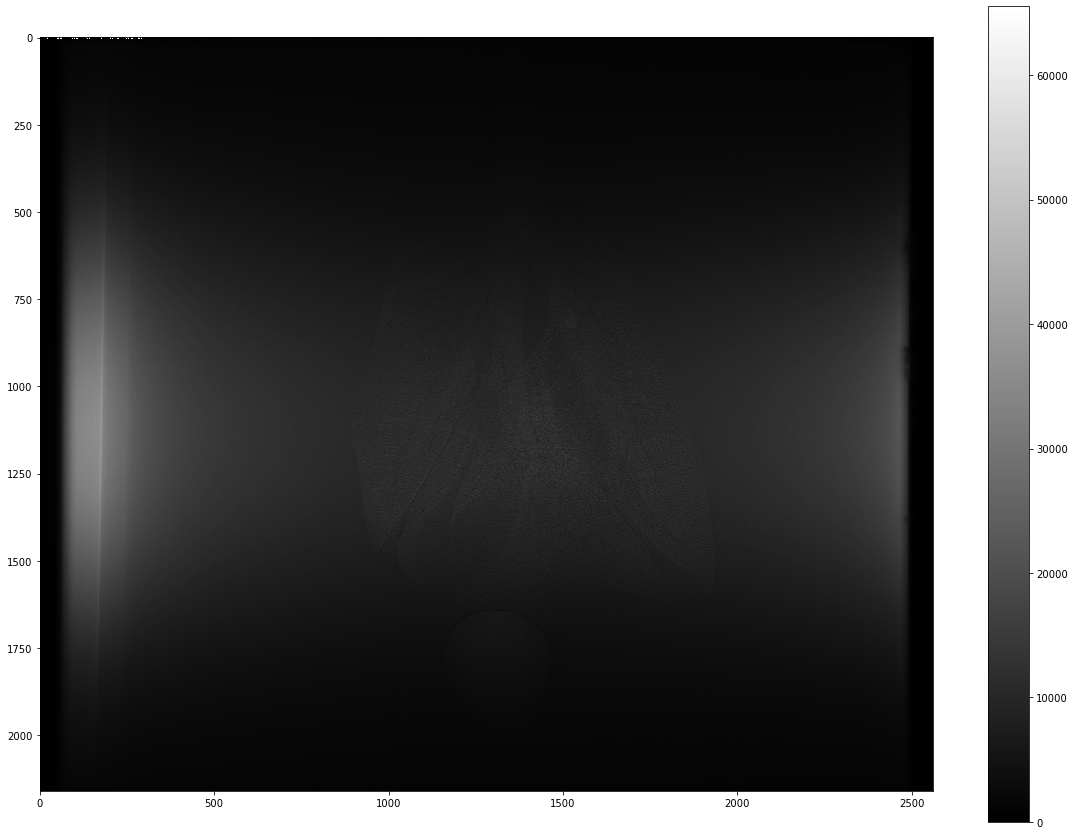

In [3]:
# Display the first converted projection
with h5py.File(xtract_input_convert_h5, 'r') as f:    
    fig, ax = plt.subplots(figsize=(20, 15))
    fig.colorbar( ax.imshow(f['exchange/data'][0] , cmap='gray'), ax=ax)  
    plt.show()

In [4]:
# Create a dictionary of general X-TRACT application parameters that
# are shared between the PreProc, Workflow and Recon applications.
# For a full description of possible parameters, see the
# XLICTWorkflow Parameter Description.xlsx spreadsheet in the docs folder.

dictParamsCore = { 
    'energy': '30',                              # keV
    'pixel_size' : '19.25',                      # um
    'dark_correction' : '1',                     # on
    'flat_correction' : '1',                     # on
    'flat_method' : '0',                         # average flats
    'phase_extraction_pbi': '1',                 # on
    'phase_extraction_pbi_method' : '0',         # TIE-Hom
    'phase_extraction_pbi_rprime' : '30000',     # um
    'phase_extraction_delta_to_beta' : '1000'    # Delta-to-Beta ratio
}

print( dictParamsCore )

{'energy': '30', 'pixel_size': '19.25', 'dark_correction': '1', 'flat_correction': '1', 'flat_method': '0', 'phase_extraction_pbi': '1', 'phase_extraction_pbi_method': '0', 'phase_extraction_pbi_rprime': '30000', 'phase_extraction_delta_to_beta': '1000'}


In [4]:
# Create a dictionary for XLIPreProc specific parameters, 
# added to from dictParamsCore
dictPreProc = dictParamsCore.copy()
dictPreProc['hdf5_input_file'] = xtract_input_convert_h5
dictPreProc['hdf5_output_file'] = xtract_output_preproc_h5
dictPreProc['output_sinograms'] = '1'                            # Output sinograms
dictPreProc['proj'] = 'dummy'                                    # This is set to work-around a bug, can be anything

print( dictPreProc )

{'energy': '30', 'pixel_size': '19.25', 'dark_correction': '1', 'flat_correction': '1', 'flat_method': '0', 'phase_extraction_pbi': '1', 'phase_extraction_pbi_method': '0', 'phase_extraction_pbi_rprime': '30000', 'phase_extraction_delta_to_beta': '1000', 'hdf5_input_file': '/mnt/Data/19-2-R2173-Lung/test_x-tract_convert.h5', 'hdf5_output_file': '/mnt/Data/19-2-R2173-Lung/test_x-tract_preproc.h5', 'output_sinograms': '1', 'proj': 'dummy'}


In [ ]:
# Run XLICTPreProc

cia.run_XLICTPreProc(dictPreProc) if run_on_asci else cia.run_XLICTPreProc(dictPreProc, cmdXLICTPreProcSino)

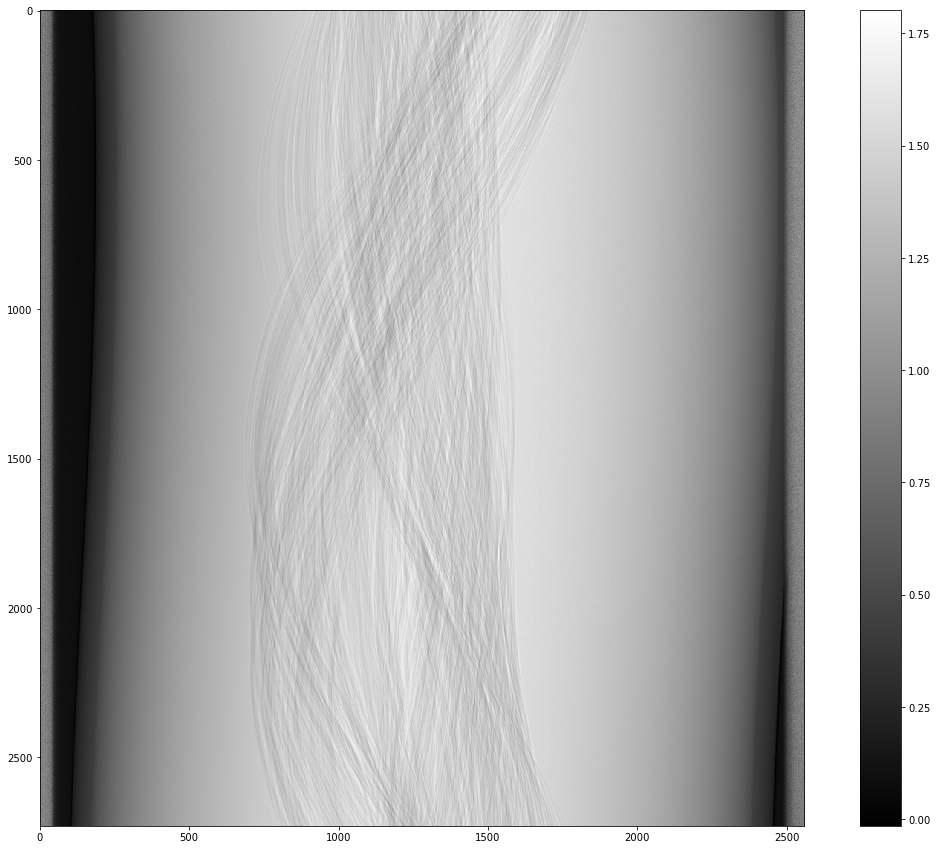

In [7]:
# Display the middle sinogram
with h5py.File(xtract_output_preproc_h5, 'r') as f:
    dset = f['exchange/data_sino']
    fig, ax = plt.subplots(figsize=(20, 15))
    fig.colorbar( ax.imshow(dset[dset.shape[0]/2] , cmap='gray'), ax=ax)  
    plt.show()

In [9]:
# Determine the number of projections in the input HDF5 file
num_proj = cia.get_num_projections(xtract_input_convert_h5)
                                 
# Use the number of projections to calculate the angle step
angle_step = 180.0 / num_proj
                                 
print( 'num_proj = {0}, angle_step = {1}'.format( num_proj, angle_step) )
                             
# Create a dictionary for XLICTWorkflow specific parameters
dictWorkflow = dictParamsCore.copy()
dictWorkflow['hdf5_input_file'] = xtract_input_convert_h5
dictWorkflow['hdf5_output_file'] = xtract_output_ctworkflow_h5
dictWorkflow['cor_method'] = '2'                                    # error method
dictWorkflow['recon_method'] = '0'                                  # FBP (GPU) 
dictWorkflow['recon_out_mu'] = '1'                                  # recon output as Mu values
dictWorkflow['zslice_range_method'] = '0'                           # reconstruct all slices
dictWorkflow['angle_step'] = str(angle_step)                        # angle step (degrees)
#dictPreProc['output_sinograms'] = '1'                               # Output sinograms

print(dictWorkflow)

num_proj = 2730, angle_step = 0.06593406593406594
{'energy': '30', 'pixel_size': '19.25', 'dark_correction': '1', 'flat_correction': '1', 'flat_method': '0', 'phase_extraction_pbi': '1', 'phase_extraction_pbi_method': '0', 'phase_extraction_pbi_rprime': '30000', 'phase_extraction_delta_to_beta': '1000', 'hdf5_input_file': '/mnt/Data/19-2-R2173-Lung/test_x-tract_convert.h5', 'hdf5_output_file': '/mnt/Data/19-2-R2173-Lung/test_x-tract_ctworkflow.h5', 'cor_method': '2', 'recon_method': '0', 'recon_out_mu': '1', 'zslice_range_method': '0', 'angle_step': '0.06593406593406594'}


In [ ]:
# Run XLICTWorkflow
cia.run_XLICTWorkflow(dictWorkflow) if run_on_asci else cia.run_XLICTWorkflow(dictWorkflow, cmdXLICTWorkflowMPI)

Rank: 0 Host: calculuslin-cl
ARGS/OPT: First Args:
1: /home/tho78s/development/X-TRACT-trunk/build/linux/XLICTWorkflowMPI.exe

Options:

-af, --angle_file:
Not set

-am, --angle_method:
Not set

-as, --angle_step:
0.06593406593406594

-cor, --cor_method:
2

-corm, --cor_manual:
Not set

-cors, --cor_sinogram_index:
Not set

-dc, --dark_correction:
1

-drg, --darks:
Not set

-e, --energy:
30

-fa, --average_filter:
Not set

-fb, --flat_size_batch:
Not set

-fc, --flat_correction:
1

-fd, --flat_subtract_dark:
Not set

-fm, --flat_method:
0

-fn, --flat_size_interval:
Not set

-fr, --recon_filter:
Not set

-fre, --recon_filter_enabled:
Not set

-frg, --flats:
Not set

-frr, --ring_filter_reconslice:
Not set

-frs, --ring_filter_sinogram:
Not set

-fz, --zingers_filter:
Not set

-fzs, --zingers_filter_size:
Not set

-fzt, --zingers_filter_threshold:
Not set

-h5fo, --hdf5_copy_input_files:
Not set

-h5if, --hdf5_input_file:
/mnt/Data/19-2-R2173-Lung/test_x-tract_convert.h5

-h5io, --hdf5_

In [ ]:
# Display the middle reconstructed slice
with h5py.File(xtract_output_ctworkflow_h5, 'r') as f:
    dset = f['exchange/data_recon']
    fig, ax = plt.subplots(figsize=(20, 15))
    fig.colorbar( ax.imshow(dset[dset.shape[0]/2] , cmap='gray'), ax=ax)  
    plt.show()